# Dense network
Finally, try with neural networks

In [1]:
import importlib; import cours_proj4_funcs; 
importlib.reload(cours_proj4_funcs)
from cours_proj4_funcs import f_read_npzF, f_addIdxFeat, f_fileApp

In [2]:
import numpy as np
import os

X_tr_ini, y_tr_ini, X_data_tr, fnames_tr, y_cat_tr = f_read_npzF(os.path.join('data', 'data_train.npz'))
X_tr_ini1 = f_addIdxFeat(X_tr_ini)

X_va_ini, y_va_ini, X_data_va, fnames_va, y_cat_va = f_read_npzF(os.path.join('data', 'data_valid.npz'))
X_va_ini1 = f_addIdxFeat(X_va_ini)

X_te_ini, y_te_ini, X_data_te, fnames_te, y_cat_te = f_read_npzF(os.path.join('data', 'data_test.npz'))
X_te_ini1 = f_addIdxFeat(X_te_ini)

In [3]:
# Standardize
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_tr_ini_scal = scaler.fit_transform(X_tr_ini)
X_va_ini_scal = scaler.transform(X_va_ini)
X_te_ini_scal = scaler.transform(X_te_ini)

In [4]:
# Function to get batches of data
def f_get_batches(X, y, batch_size):
    # Enumerate indexes by steps of batch_size
    # i: 0, b, 2b, 3b, 4b, .. where b is the batch size
    for i in range(0, len(y), batch_size):
        # "yield" data between index i and i+b (not included)
        yield X[i : i+batch_size], y[i : i+batch_size]

##### 1-layer dense network i.e. no hidden layer, just the input and output ones

In [5]:
##**** Wiring.. ***
import tensorflow as tf
# y_hat = Xw + 𝑏 ; => y_hat = aX + b

# Create placeholders
X = tf.placeholder( dtype=tf.float32, shape=[None, 1280] ) # 1280 result from the high feature
                
y = tf.placeholder( dtype=tf.int32, shape=[None] ) # Vector of target values

# Create variables
W = tf.Variable( tf.zeros(shape=(1280, 6)) )
b = tf.Variable( tf.zeros(shape=(6)) )

# Compute logits
logits = tf.matmul(X, W) + b

# Cross-entropy loss function
ce = tf.nn.sparse_softmax_cross_entropy_with_logits( labels = y, logits = logits )

# Mean cross-entropy
mean_ce = tf.reduce_mean(ce)

# Gradient descent
lr = tf.placeholder( dtype=tf.float32 )
gd = tf.train.GradientDescentOptimizer( learning_rate=lr )

# Minimize cross-entropy
train_op = gd.minimize(mean_ce)

# Compute predictions
predictions = tf.argmax( logits # shape: (n, 6)
                        ,axis = 1 # class with max logit
                        ,output_type = tf.int32 ) # Same type as labels
                        

# Are the predictions correct?
is_correct = tf.equal(y, predictions)

# Accuracy
accuracy = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32) #Convert booleans to 0/1 float numbers
                          )

In [6]:
##********* Run training using batch generator...

%matplotlib inline
import matplotlib.pyplot as plt

# Accuracy scores after each batch
train_acc_values = []
valid_acc_values = []

# Initialization operation
initialization_op = tf.global_variables_initializer()

with tf.Session() as sess:
    # Initialize the graph
    sess.run(initialization_op)
    
    # Get batches of data
    for X_batch, y_batch in f_get_batches(X_tr_ini_scal, y_tr_ini, 64):
        #print(X_batch.shape, y_batch.shape)
        
        # Run training and evaluate accuracy
        _, train_acc = sess.run( [train_op, accuracy]
                                ,feed_dict={ X: X_batch
                                            ,y: y_batch
                                            ,lr: 0.001 } ) # Learning rate
                                
        
        train_acc_values.append(train_acc)
        
        # Evaluate validation accuracy
        valid_acc = sess.run(accuracy
                             ,feed_dict={X: X_va_ini_scal
                                        ,y: y_va_ini } )
        
        valid_acc_values.append(valid_acc)
        
    # Get weight matrix and biases
    W_fitted = W.eval()
    b_fitted = b.eval()

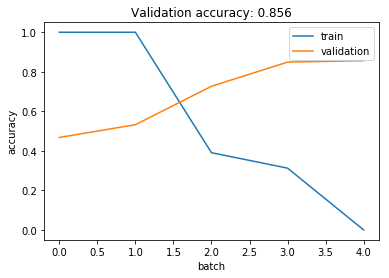

In [7]:
# Plot accuracy values
plt.plot(train_acc_values, label='train')
plt.plot(valid_acc_values, label='validation')

plt.title('Validation accuracy: {:.3f}'
          .format(valid_acc_values[-1]) )# Last validation accuracy value

plt.xlabel('batch')
plt.ylabel('accuracy')

plt.legend()
plt.show()

In [8]:
# Initialization operation
initialization_op = tf.global_variables_initializer()

with tf.Session() as sess:
    # Initialize the graph
    sess.run(initialization_op)
    
    # Compute test accuracy
    acc_val = sess.run(accuracy
                       ,feed_dict ={ X: X_te_ini_scal
                                    ,y: y_te_ini
                                    ,W: W_fitted     # Set weights
                                    ,b: b_fitted } ) # Set biases
                                
    print('Test accuracy: {:.3f}'.format(acc_val))

Test accuracy: 0.880


In [9]:
acc_val
# Decision tree accuracy to append into the file 
f_fileApp('data/results09.csv',6,"1-layer nn", acc_val)

#### 2-layer dense network i.e. one hidden layer

In [10]:
import tensorflow as tf

# Create the graph, using the dense() function from 
# the layers module and the TensorFlow initializers.
graph = tf.Graph()

with graph.as_default():
    # Create placeholders
    X = tf.placeholder(dtype=tf.float32, shape=[None, 1280])
    y = tf.placeholder(dtype=tf.int32, shape=[None])

    # Hidden layer with 16 units
    hidden = tf.layers.dense(X    #intput data
                            ,16   #nbr of output units
                            ,activation = tf.nn.relu   # ReLU, # Activation function
                            ,kernel_initializer = tf.variance_scaling_initializer(scale=2, seed=0)  # Weights initializer
                            ,bias_initializer = tf.zeros_initializer()  # bias initializer
                            ,name = 'hidden' ) # Layer name

    # Output layer
    logits = tf.layers.dense(hidden  #intput data
                            ,6      #nbr of output units
                            ,activation = None   #No activation function
                            ,kernel_initializer = tf.variance_scaling_initializer(scale=1, seed=0)  # Weights initializer
                            ,bias_initializer = tf.zeros_initializer()  # bias initializer
                            ,name = 'output' )  # Layer name

In [11]:
# We can inspect the variables from the graph
with graph.as_default():
    # Get variables in the graph
    for v in tf.trainable_variables():
        print(v)

<tf.Variable 'hidden/kernel:0' shape=(1280, 16) dtype=float32_ref>
<tf.Variable 'hidden/bias:0' shape=(16,) dtype=float32_ref>
<tf.Variable 'output/kernel:0' shape=(16, 6) dtype=float32_ref>
<tf.Variable 'output/bias:0' shape=(6,) dtype=float32_ref>


In [12]:
#retrieving the variables
with graph.as_default():
    # Get weights/biases of the hidden layer
    with tf.variable_scope('hidden', reuse=True):
        W1 = tf.get_variable('kernel')
        b1 = tf.get_variable('bias')

    # Get weights/biases of the output layer
    with tf.variable_scope('output', reuse=True):
        W2 = tf.get_variable('kernel')
        b2 = tf.get_variable('bias')

In [13]:
# Loss function and training operation
with graph.as_default():
    # Loss fuction: mean cross-entropy
    mean_ce = tf.reduce_mean( tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
                            )

    # Gradient descent
    lr = tf.placeholder(dtype =tf.float32)
    
    gd = tf.train.GradientDescentOptimizer(learning_rate = lr)

    # Minimize cross-entropy
    train_op = gd.minimize(mean_ce)

    # Compute predictions and accuracy
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    
    is_correct = tf.equal(y, predictions)
    
    accuracy = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))

In [14]:
# Batch generator
def f_get_batches(X, y, batch_size):
    # Shuffle X,y
    shuffled_idx = np.arange(len(y)) # 1,2,...,n
    np.random.shuffle(shuffled_idx)

    # Enumerate indexes by steps of batch_size
    # i: 0, b, 2b, 3b, 4b, .. where b is the batch size
    for i in range(0, len(y), batch_size):
        
        # Batch indexes
        batch_idx = shuffled_idx[i : i+batch_size]
        
        yield X[batch_idx], y[batch_idx]

In [15]:
# Validation accuracy
valid_acc_values = []

with tf.Session(graph=graph) as sess:
    # Initialize variables
    sess.run( tf.global_variables_initializer() )

    # Set seed
    np.random.seed(0)

    # Train several epochs
    for epoch in range(50):
        # Accuracy values (train) after each batch
        batch_acc = []

        # Get batches of data
        for X_batch, y_batch in f_get_batches(X_tr_ini_scal, y_tr_ini, 64):
            # Run training and evaluate accuracy
            _, acc_value = sess.run([train_op, accuracy]
                                    ,feed_dict ={X: X_batch
                                                ,y: y_batch
                                                ,lr: 0.01 } # Learning rate
                                    )

            # Save accuracy (current batch)
            batch_acc.append(acc_value)
        
        # Evaluate validation accuracy
        valid_acc = sess.run(accuracy
                             ,feed_dict ={X: X_va_ini_scal
                                         ,y: y_va_ini  } )
        
        valid_acc_values.append(valid_acc)

        # Print progress
        print('Epoch {} - valid: {:.3f} train: {:.3f} (mean)'.format(epoch+1, valid_acc, np.mean(batch_acc) ))
    
    
    # Weights of the hidden and output layers
    weights_hidden = W1.eval()
    weights_output = W2.eval()
    
    # Evaluate test accuracy
    test_acc = sess.run( accuracy
                        ,feed_dict ={ X: X_te_ini_scal #X_test
                                     ,y: y_te_ini #y_test
                                     #,training: False 
                                     } )
    
    print('Test accuracy: {:.3f}'.format(test_acc))
    
# Prints:
# Epoch 1 - valid: 0.800 train: 0.627 (mean)
# Epoch 2 - valid: 0.896 train: 0.851 (mean)
# Epoch 3 - valid: 0.904 train: 0.882 (mean)
# ...
# Epoch 48 - valid: 0.950 train: 0.968 (mean)
# Epoch 49 - valid: 0.952 train: 0.969 (mean)
# Epoch 50 - valid: 0.952 train: 0.969 (mean)

Epoch 1 - valid: 0.388 train: 0.280 (mean)
Epoch 2 - valid: 0.482 train: 0.456 (mean)
Epoch 3 - valid: 0.554 train: 0.523 (mean)
Epoch 4 - valid: 0.604 train: 0.595 (mean)
Epoch 5 - valid: 0.619 train: 0.635 (mean)
Epoch 6 - valid: 0.662 train: 0.691 (mean)
Epoch 7 - valid: 0.712 train: 0.783 (mean)
Epoch 8 - valid: 0.763 train: 0.841 (mean)
Epoch 9 - valid: 0.777 train: 0.872 (mean)
Epoch 10 - valid: 0.791 train: 0.891 (mean)
Epoch 11 - valid: 0.813 train: 0.901 (mean)
Epoch 12 - valid: 0.813 train: 0.904 (mean)
Epoch 13 - valid: 0.820 train: 0.918 (mean)
Epoch 14 - valid: 0.820 train: 0.931 (mean)
Epoch 15 - valid: 0.827 train: 0.951 (mean)
Epoch 16 - valid: 0.842 train: 0.957 (mean)
Epoch 17 - valid: 0.842 train: 0.952 (mean)
Epoch 18 - valid: 0.849 train: 0.966 (mean)
Epoch 19 - valid: 0.849 train: 0.969 (mean)
Epoch 20 - valid: 0.849 train: 0.967 (mean)
Epoch 21 - valid: 0.849 train: 0.973 (mean)
Epoch 22 - valid: 0.849 train: 0.978 (mean)
Epoch 23 - valid: 0.856 train: 0.978 (mea

In [16]:
# Decision tree accuracy to append into the file 
f_fileApp('data/results09.csv',7,"2-layer nn", test_acc)

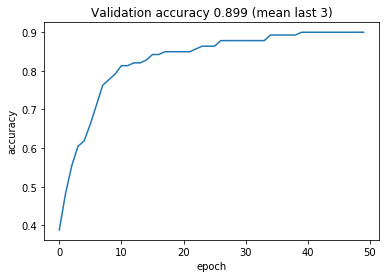

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot accuracy values
plt.plot(valid_acc_values)

plt.title('Validation accuracy {:.3f} (mean last 3)'.format(np.mean(valid_acc_values[-3:]) )) # last three values 

plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.show()